In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface, VAEPWVolSurface, VAEVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

In [2]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [3]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-22 23:28:28] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-22 23:28:40] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-22 23:28:42] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-22 23:28:42] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


# Baseline, 9*8  params already tuned

In [24]:
model_name = "vae_pw_improve_0"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [25]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [26]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-22 23:30:46] [INFO] src.train (62) : Using device: mps


In [18]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [19]:
mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

In [20]:
df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

In [21]:
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
# !only for test run
# pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [27]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [13]:
trainer.hypertune(train_loader)

Hypertune!! {'learning_rate': <ray.tune.search.sample.Categorical object at 0x17ba88130>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x17ba887f0>, 'latent_dim': <ray.tune.search.sample.Categorical object at 0x17ba88310>, 'hidden_dim': <ray.tune.search.sample.Categorical object at 0x17ba894b0>, 'input_dim': <ray.tune.search.sample.Categorical object at 0x17ba8a290>}


2025-04-22 23:28:54,323	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


KeyboardInterrupt: 

In [28]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-22 23:30:51] [INFO] train (3) : Epoch 1/10


MSE: 14.254247665405273, KLD: 4.41684627532959
MSE: 15.321501731872559, KLD: 4.516442775726318
MSE: 15.195013999938965, KLD: 4.541093826293945
MSE: 14.645025253295898, KLD: 4.583986759185791
MSE: 14.576742172241211, KLD: 4.587629795074463
MSE: 12.592547416687012, KLD: 4.6692047119140625
MSE: 15.37057876586914, KLD: 4.756248950958252
MSE: 14.573760986328125, KLD: 4.7566022872924805
MSE: 13.496377944946289, KLD: 4.816339492797852
MSE: 13.901220321655273, KLD: 4.882941722869873
MSE: 13.540525436401367, KLD: 4.888560771942139
MSE: 12.496484756469727, KLD: 4.936617374420166
MSE: 13.501449584960938, KLD: 5.038455009460449
MSE: 12.870001792907715, KLD: 5.040770530700684
MSE: 12.35045337677002, KLD: 5.127554893493652
MSE: 12.368680953979492, KLD: 5.1424241065979
MSE: 12.849742889404297, KLD: 5.206228256225586
MSE: 12.053153991699219, KLD: 5.258218288421631
MSE: 12.632606506347656, KLD: 5.301307678222656
MSE: 11.532793998718262, KLD: 5.350833892822266
MSE: 11.521775245666504, KLD: 5.42607831954

[2025-04-22 23:32:30] [INFO] src.train (181) : Loss: 0.0084
[2025-04-22 23:32:30] [INFO] train (3) : Epoch 2/10


MSE: 0.7299595475196838, KLD: 0.11512178182601929
MSE: 0.22692757844924927, KLD: 0.016933321952819824
MSE: 0.7118080854415894, KLD: 0.11115536093711853
MSE: 0.7135236263275146, KLD: 0.10661214590072632
MSE: 0.75858074426651, KLD: 0.10233855247497559
MSE: 1.1622185707092285, KLD: 0.09864151477813721
MSE: 2.209199905395508, KLD: 0.11960813403129578
MSE: 1.1128532886505127, KLD: 0.1050417423248291
MSE: 0.8359123468399048, KLD: 0.08888253569602966
MSE: 0.7970403432846069, KLD: 0.10464602708816528
MSE: 0.8140119910240173, KLD: 0.10439634323120117
MSE: 1.4711740016937256, KLD: 0.1023755669593811
MSE: 1.0204529762268066, KLD: 0.08447307348251343
MSE: 0.9868841767311096, KLD: 0.09719425439834595
MSE: 1.0811673402786255, KLD: 0.11933165788650513
MSE: 0.8152865171432495, KLD: 0.11199596524238586
MSE: 1.0616199970245361, KLD: 0.1041976809501648
MSE: 0.9305121302604675, KLD: 0.10397034883499146
MSE: 1.184104323387146, KLD: 0.13143059611320496
MSE: 0.8078818917274475, KLD: 0.13705676794052124
MSE: 

[2025-04-22 23:34:09] [INFO] src.train (181) : Loss: 0.0061
[2025-04-22 23:34:09] [INFO] train (3) : Epoch 3/10


MSE: 0.16880716383457184, KLD: 0.4257606267929077
MSE: 0.504888117313385, KLD: 1.8781700134277344
MSE: 0.6032575368881226, KLD: 1.7940561771392822
MSE: 0.649124026298523, KLD: 1.8850126266479492
MSE: 0.5332235097885132, KLD: 1.7671113014221191
MSE: 0.6483594179153442, KLD: 1.8988943099975586
MSE: 0.49308598041534424, KLD: 1.6134355068206787
MSE: 0.4258052706718445, KLD: 1.6984949111938477
MSE: 0.6827603578567505, KLD: 1.5396106243133545
MSE: 0.5476328730583191, KLD: 1.9317238330841064
MSE: 0.5078637599945068, KLD: 1.7664296627044678
MSE: 0.5815166234970093, KLD: 2.1485488414764404
MSE: 0.5284930467605591, KLD: 1.7547423839569092
MSE: 0.7097015380859375, KLD: 1.5839704275131226
MSE: 0.6138249635696411, KLD: 1.7501143217086792
MSE: 1.0570082664489746, KLD: 1.5702847242355347
MSE: 0.5941069722175598, KLD: 1.8262343406677246
MSE: 0.6170538663864136, KLD: 1.7678520679473877
MSE: 0.5005733966827393, KLD: 1.450183629989624
MSE: 0.6022769212722778, KLD: 1.7320060729980469
MSE: 0.63625311851501

[2025-04-22 23:35:48] [INFO] src.train (181) : Loss: 0.0050
[2025-04-22 23:35:48] [INFO] train (3) : Epoch 4/10


MSE: 0.40037018060684204, KLD: 1.3898308277130127
MSE: 0.6633305549621582, KLD: 1.3549455404281616
MSE: 0.6190798282623291, KLD: 1.5607714653015137
MSE: 0.7519318461418152, KLD: 1.2962000370025635
MSE: 0.38209226727485657, KLD: 1.2602653503417969
MSE: 0.717896044254303, KLD: 1.7450188398361206
MSE: 0.4989809989929199, KLD: 1.1181789636611938
MSE: 0.566748857498169, KLD: 1.3048254251480103
MSE: 0.43170851469039917, KLD: 1.2937357425689697
MSE: 0.5002069473266602, KLD: 1.300856113433838
MSE: 0.17077139019966125, KLD: 0.38825684785842896
MSE: 0.5108662843704224, KLD: 1.163801670074463
MSE: 0.45397353172302246, KLD: 1.355375051498413
MSE: 0.6141811609268188, KLD: 1.543830394744873
MSE: 0.6252972483634949, KLD: 1.4396018981933594
MSE: 0.7196364402770996, KLD: 1.2109860181808472
MSE: 0.4571716785430908, KLD: 1.1711034774780273
MSE: 0.4690755009651184, KLD: 1.5671473741531372
MSE: 0.6167332530021667, KLD: 1.287354588508606
MSE: 0.6436089277267456, KLD: 1.6615337133407593
MSE: 0.79731464385986

[2025-04-22 23:37:25] [INFO] src.train (181) : Loss: 0.0047
[2025-04-22 23:37:25] [INFO] train (3) : Epoch 5/10


MSE: 0.5228821039199829, KLD: 0.976000189781189
MSE: 0.45603734254837036, KLD: 1.0820282697677612
MSE: 0.5421544909477234, KLD: 1.1765168905258179
MSE: 0.6773346066474915, KLD: 1.208225131034851
MSE: 0.470516562461853, KLD: 0.9726535081863403
MSE: 0.13564983010292053, KLD: 0.25999385118484497
MSE: 0.43764856457710266, KLD: 1.0480456352233887
MSE: 0.9131516218185425, KLD: 0.9649413824081421
MSE: 0.5082874298095703, KLD: 1.106326699256897
MSE: 0.5067962408065796, KLD: 0.9297467470169067
MSE: 0.4392397105693817, KLD: 0.8827767372131348
MSE: 0.5741218328475952, KLD: 1.143951177597046
MSE: 0.4350517988204956, KLD: 0.895950198173523
MSE: 0.34129610657691956, KLD: 0.8732572793960571
MSE: 0.5046782493591309, KLD: 0.8921055793762207
MSE: 0.5214579105377197, KLD: 0.9666329026222229
MSE: 0.5764156579971313, KLD: 1.0804579257965088
MSE: 0.6421317458152771, KLD: 1.082984447479248
MSE: 0.43620917201042175, KLD: 0.9620678424835205
MSE: 0.62868732213974, KLD: 1.1050523519515991
MSE: 0.4849986433982849

[2025-04-22 23:39:05] [INFO] src.train (181) : Loss: 0.0044
[2025-04-22 23:39:05] [INFO] train (3) : Epoch 6/10


MSE: 0.5636066198348999, KLD: 0.6759223341941833
MSE: 0.5246990919113159, KLD: 0.8595412969589233
MSE: 0.5860323309898376, KLD: 0.8631852865219116
MSE: 0.49102482199668884, KLD: 0.8639293909072876
MSE: 0.49692636728286743, KLD: 0.8648743629455566
MSE: 0.4844962954521179, KLD: 0.8542299270629883
MSE: 1.6174168586730957, KLD: 0.8035281300544739
MSE: 0.4736897051334381, KLD: 0.8483521938323975
MSE: 0.45564109086990356, KLD: 0.8684617877006531
MSE: 0.5290206670761108, KLD: 0.9841099977493286
MSE: 0.4805114269256592, KLD: 0.8431715965270996
MSE: 0.5303630828857422, KLD: 0.8819881677627563
MSE: 0.377410888671875, KLD: 0.7821273803710938
MSE: 0.6215037107467651, KLD: 0.9262903928756714
MSE: 0.5847198367118835, KLD: 0.953586220741272
MSE: 0.4700278043746948, KLD: 0.8374974727630615
MSE: 0.6698837280273438, KLD: 0.81742262840271
MSE: 0.13947299122810364, KLD: 0.26629140973091125
MSE: 0.4960014820098877, KLD: 0.8896488547325134
MSE: 0.38993948698043823, KLD: 0.8267258405685425
MSE: 0.62121057510

[2025-04-22 23:40:43] [INFO] src.train (181) : Loss: 0.0043
[2025-04-22 23:40:43] [INFO] train (3) : Epoch 7/10


MSE: 0.5757179260253906, KLD: 0.7331174612045288
MSE: 0.6540892720222473, KLD: 0.7143018245697021
MSE: 0.8977358341217041, KLD: 0.797200083732605
MSE: 0.45027416944503784, KLD: 0.6655486822128296
MSE: 0.5733442306518555, KLD: 0.824228048324585
MSE: 0.37987831234931946, KLD: 0.7130952477455139
MSE: 0.7378047108650208, KLD: 0.7157758474349976
MSE: 0.5348204374313354, KLD: 0.7097150087356567
MSE: 0.741126298904419, KLD: 0.8424335718154907
MSE: 0.4147893786430359, KLD: 0.83100426197052
MSE: 0.39949172735214233, KLD: 0.6075756549835205
MSE: 0.6045360565185547, KLD: 0.8745861649513245
MSE: 0.5884338021278381, KLD: 0.8043110370635986
MSE: 0.42280861735343933, KLD: 0.7696636319160461
MSE: 0.5525272488594055, KLD: 0.712101936340332
MSE: 0.09849777072668076, KLD: 0.19489780068397522
MSE: 0.5050466060638428, KLD: 0.7112995982170105
MSE: 1.018125295639038, KLD: 0.7752494812011719
MSE: 0.4841666519641876, KLD: 0.751432478427887
MSE: 0.6165233254432678, KLD: 0.7123591303825378
MSE: 0.715070724487304

[2025-04-22 23:42:21] [INFO] src.train (181) : Loss: 0.0042
[2025-04-22 23:42:21] [INFO] train (3) : Epoch 8/10


MSE: 0.3458986282348633, KLD: 0.5761092901229858
MSE: 0.4167935848236084, KLD: 0.7288641929626465
MSE: 0.43684110045433044, KLD: 0.6375349164009094
MSE: 0.3408556282520294, KLD: 0.5988081693649292
MSE: 0.41159263253211975, KLD: 0.6619813442230225
MSE: 0.42344266176223755, KLD: 0.6510614156723022
MSE: 0.913676917552948, KLD: 0.6628800630569458
MSE: 0.46693646907806396, KLD: 0.6451274156570435
MSE: 0.7857235670089722, KLD: 0.6455788612365723
MSE: 0.1368676871061325, KLD: 0.1792111098766327
MSE: 0.3927215039730072, KLD: 0.6347726583480835
MSE: 0.4108116626739502, KLD: 0.6418484449386597
MSE: 0.5116063356399536, KLD: 0.7474151253700256
MSE: 8.60392951965332, KLD: 0.656823456287384
MSE: 0.5013109445571899, KLD: 0.6691846251487732
MSE: 0.486672043800354, KLD: 0.6678774952888489
MSE: 0.4420475363731384, KLD: 0.6272023916244507
MSE: 0.4720478355884552, KLD: 0.6621184349060059
MSE: 0.5292710065841675, KLD: 0.6996722221374512
MSE: 0.47081318497657776, KLD: 0.5497376322746277
MSE: 0.4259107112884

[2025-04-22 23:43:59] [INFO] src.train (181) : Loss: 0.0041
[2025-04-22 23:43:59] [INFO] train (3) : Epoch 9/10


MSE: 0.48737239837646484, KLD: 0.5090259313583374
MSE: 0.7281216979026794, KLD: 0.5142111778259277
MSE: 0.46587738394737244, KLD: 0.5782637596130371
MSE: 0.5398088693618774, KLD: 0.5374133586883545
MSE: 0.3946688175201416, KLD: 0.507968544960022
MSE: 0.7150450944900513, KLD: 0.5513521432876587
MSE: 0.3937447667121887, KLD: 0.5510613918304443
MSE: 0.6406189799308777, KLD: 0.5855591893196106
MSE: 0.5775130987167358, KLD: 0.5683139562606812
MSE: 0.3688182234764099, KLD: 0.49159473180770874
MSE: 0.4989577829837799, KLD: 0.64641273021698
MSE: 0.4989390969276428, KLD: 0.576505184173584
MSE: 0.4531030058860779, KLD: 0.5460711717605591
MSE: 0.42190587520599365, KLD: 0.530382513999939
MSE: 0.5293790698051453, KLD: 0.6118741035461426
MSE: 0.4478309452533722, KLD: 0.5275875926017761
MSE: 0.1172894537448883, KLD: 0.15441665053367615
MSE: 0.43095865845680237, KLD: 0.6369692087173462
MSE: 0.5443661212921143, KLD: 0.5992306470870972
MSE: 0.3615546226501465, KLD: 0.5411470532417297
MSE: 0.437962234020

[2025-04-22 23:45:37] [INFO] src.train (181) : Loss: 0.0041
[2025-04-22 23:45:37] [INFO] train (3) : Epoch 10/10


MSE: 0.5126213431358337, KLD: 0.458151251077652
MSE: 0.44660669565200806, KLD: 0.53653883934021
MSE: 0.3925694525241852, KLD: 0.5666961669921875
MSE: 0.4425027072429657, KLD: 0.4907986521720886
MSE: 0.5025253891944885, KLD: 0.5146297216415405
MSE: 0.46728020906448364, KLD: 0.5739725232124329
MSE: 0.4629955291748047, KLD: 0.5922104120254517
MSE: 0.40915364027023315, KLD: 0.4882453680038452
MSE: 0.49708110094070435, KLD: 0.5585383176803589
MSE: 0.5429145693778992, KLD: 0.5449415445327759
MSE: 0.8867688179016113, KLD: 0.6388295888900757
MSE: 0.42268234491348267, KLD: 0.5230346918106079
MSE: 0.3698422908782959, KLD: 0.47607195377349854
MSE: 0.45944464206695557, KLD: 0.5971474647521973
MSE: 0.4095226526260376, KLD: 0.5654062032699585
MSE: 0.6488058567047119, KLD: 0.5532530546188354
MSE: 0.6881747841835022, KLD: 0.5512557029724121
MSE: 0.4605042338371277, KLD: 0.5527623891830444
MSE: 0.39594531059265137, KLD: 0.5353814959526062
MSE: 0.4796358644962311, KLD: 0.5454990863800049
MSE: 0.79964852

[2025-04-22 23:47:15] [INFO] src.train (181) : Loss: 0.0040


MSE: 0.41170042753219604, KLD: 0.5048766732215881
MSE: 0.4862390160560608, KLD: 0.53892582654953
MSE: 0.41803601384162903, KLD: 0.4662148356437683
MSE: 0.40495067834854126, KLD: 0.45867958664894104
MSE: 0.4578261375427246, KLD: 0.42862147092819214
MSE: 0.49636775255203247, KLD: 0.49125969409942627
MSE: 0.4392322897911072, KLD: 0.43424883484840393
MSE: 0.361246258020401, KLD: 0.434751957654953
MSE: 0.39996030926704407, KLD: 0.48756614327430725
MSE: 0.5322974920272827, KLD: 0.4360488951206207
MSE: 0.4831860065460205, KLD: 0.512978196144104
MSE: 0.586655855178833, KLD: 0.45939943194389343
MSE: 0.37860438227653503, KLD: 0.4130233824253082
MSE: 1.0260653495788574, KLD: 0.4278694987297058
MSE: 0.5749510526657104, KLD: 0.4896291196346283
MSE: 0.5393828749656677, KLD: 0.48226264119148254
MSE: 0.6578863859176636, KLD: 0.44580793380737305
MSE: 0.1649923026561737, KLD: 0.1168590784072876


In [29]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

In [30]:
trainer.load_model( f"params/{trainer.model_name}.pth")

[2025-04-22 23:47:48] [INFO] src.train (138) : Model loaded from params/vae_pw_improve_0.pth


In [33]:
vae_gen = VAEPWVolSurface(
    vae_model=trainer.model
)
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.3092856 , 0.2154534 , 0.18518086, 0.17703976, 0.17414077,
        0.16848941, 0.16594845, 0.16432323],
       [0.30094615, 0.21162145, 0.18610896, 0.17992385, 0.17671792,
        0.1718631 , 0.16932218, 0.16769688],
       [0.29154658, 0.20932133, 0.18720452, 0.18277724, 0.17925258,
        0.17578445, 0.17425294, 0.17536129],
       [0.28331617, 0.2101063 , 0.18890403, 0.1855966 , 0.18241465,
        0.18130025, 0.1833295 , 0.1842386 ],
       [0.27443188, 0.21105675, 0.19103888, 0.1893907 , 0.18797535,
        0.18857102, 0.18987079, 0.19342306],
       [0.2662081 , 0.21213937, 0.19559781, 0.19351451, 0.19556934,
        0.19836263, 0.19653557, 0.20278277],
       [0.26543513, 0.21440807, 0.19987017, 0.2034062 , 0.2024466 ,
        0.20811684, 0.21406756, 0.21811399],
       [0.2651577 , 0.2142746 , 0.207013  , 0.2159571 , 0.22216426,
        0.23104052, 0.2375865 , 0.24192499],
       [0.31778342, 0.22641987, 0.23198406, 0.25084835, 0.2611236 ,
        0.27834868, 0.290612

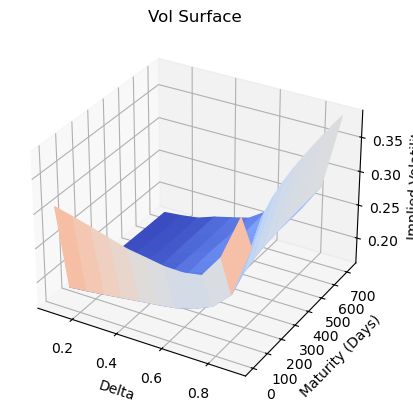

In [40]:
vae_gen.refresh()
ax = vae_gen.plot(delta_range = (0.1, 0.9), maturity_range = (1, 720))

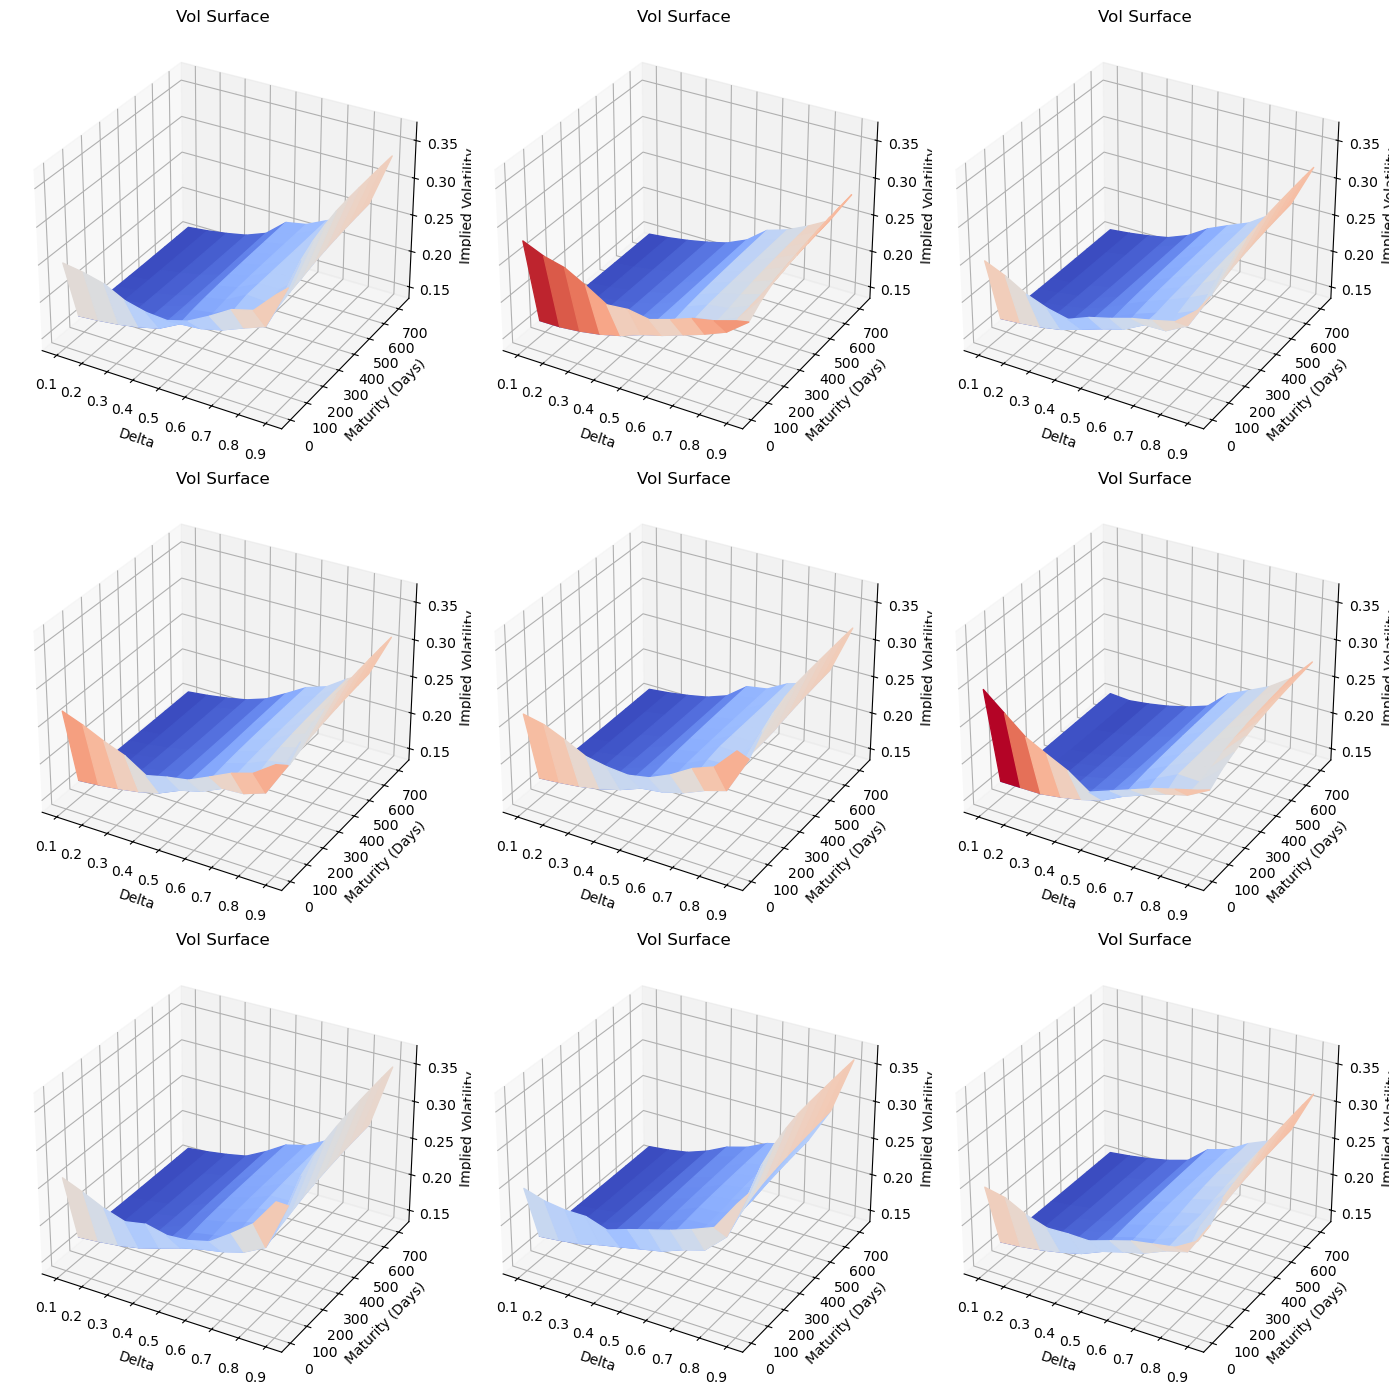

In [59]:
import matplotlib.pyplot as plt

fig_ = plt.figure(figsize=(14, 14))
axes = [[fig_.add_subplot(3, 3, i*3+j+1, projection='3d') for j in range(3)] for i in range(3)]

# First pass: generate all plots and collect z-limits
z_mins, z_maxs = [], []
for i in range(3):
    for j in range(3):
        vae_gen.refresh()
        vae_gen.plot(ax=axes[i][j], delta_range=(0.1, 0.9), maturity_range=(1, 720))
        
        # Store current z-axis limits
        z_mins.append(axes[i][j].get_zlim()[0])
        z_maxs.append(axes[i][j].get_zlim()[1])

# Calculate global limits with 5% padding
global_zmin = min(z_mins)
global_zmax = max(z_maxs)
padding = 0.05 * (global_zmax - global_zmin)

# Second pass: apply consistent z-axis limits
for i in range(3):
    for j in range(3):
        axes[i][j].set_zlim(
            global_zmin - padding, 
            global_zmax + padding
        )

plt.tight_layout()
plt.show()

In [20]:
vol_surfaces_tensor = torch.stack(vol_surfaces)

# Compute descriptive statistics
mean = vol_surfaces_tensor.mean().item()
std = vol_surfaces_tensor.std().item()
min_val = vol_surfaces_tensor.min().item()
max_val = vol_surfaces_tensor.max().item()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")

Mean: 0.18290027976036072
Standard Deviation: 0.07631000876426697
Minimum Value: 2.79548589787737e-06
Maximum Value: 0.4679392874240875


In [24]:
mean = pw_vol_data.mean().item()
std = pw_vol_data.std().item()
min_val = pw_vol_data.min().item()
max_val = pw_vol_data.max().item()
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")


Mean: 0.2202116698026657
Standard Deviation: 0.08490786701440811
Minimum Value: 0.0326480008661747
Maximum Value: 5.791611194610596


In [46]:
df['moneyness'].describe()

count    1.306655e+06
mean     6.230497e-01
std      2.978849e-01
min      2.279000e-03
25%      3.937380e-01
50%      6.850460e-01
75%      8.939310e-01
max      9.994370e-01
Name: moneyness, dtype: float64

# Grid-Based VAE

In [116]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


model_name = "vae_0"
train_model = True
load_model = False
save_model = True
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 50
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_vanilla = Trainer(model_name)
trainer_vanilla.create_model()

with open(data_dir, "r") as f:
    data = json.load(f)

vol_surfaces = []
for key in data:
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
dummy_labels = torch.zeros(len(data_tensor))

dataset = TensorDataset(data_tensor, dummy_labels)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_vanilla.batch_size,
    shuffle=True
)

# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_vanilla.train(train_loader)

if save_model:
    torch.save(
        trainer_vanilla.model.state_dict(), f"params/{trainer_vanilla.model_name}.pth"
    )


[2025-04-22 21:21:46] [INFO] src.train (62) : Using device: mps
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 1/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 1/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 1/50
[2025-04-22 21:21:46] [INFO] src.train (181) : Loss: 2.2772
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 2/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 2/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 2/50
[2025-04-22 21:21:46] [INFO] src.train (181) : Loss: 0.6482
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 3/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 3/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 3/50
[2025-04-22 21:21:46] [INFO] src.train (181) : Loss: 0.4319
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 4/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 4/50
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 4/50
[2025-04-22 21:21:46] [INFO] src.train (181) : Loss: 0.4206
[2025-04-22 21:21:46] [INFO] train (37) : Epoch 5/50
[2025-0

In [117]:
trainer_vanilla.load_model( f"params/{trainer_vanilla.model_name}.pth")

[2025-04-22 21:21:48] [INFO] src.train (138) : Model loaded from params/vae_0.pth


In [118]:
vae_gen = VAEVolSurface(
    vae_model=trainer_vanilla.model
)

vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.1813471 , 0.16633143, 0.1593354 , 0.1498068 , 0.1426222 ,
        0.13523674, 0.14558016, 0.06654051],
       [0.17012294, 0.17119485, 0.15662411, 0.148329  , 0.14847979,
        0.15354085, 0.14471199, 0.07643312],
       [0.16711791, 0.1707615 , 0.15390976, 0.16288358, 0.15662117,
        0.15776142, 0.15682268, 0.08705483],
       [0.17548312, 0.17084886, 0.1712067 , 0.16197512, 0.16792613,
        0.17529741, 0.1710887 , 0.09904251],
       [0.17510217, 0.18126215, 0.17613994, 0.18392059, 0.17757672,
        0.19432591, 0.18889433, 0.10235613],
       [0.18949074, 0.18751694, 0.19529508, 0.19199383, 0.19246021,
        0.20596948, 0.20230146, 0.11495885],
       [0.1935907 , 0.19227181, 0.1983146 , 0.19733061, 0.20639887,
        0.20858261, 0.21677244, 0.1290958 ],
       [0.19346987, 0.19191723, 0.21067668, 0.2225261 , 0.2312468 ,
        0.23367025, 0.24714218, 0.13679993],
       [0.21723616, 0.22714354, 0.24314815, 0.26095986, 0.2731142 ,
        0.29996118, 0.312464

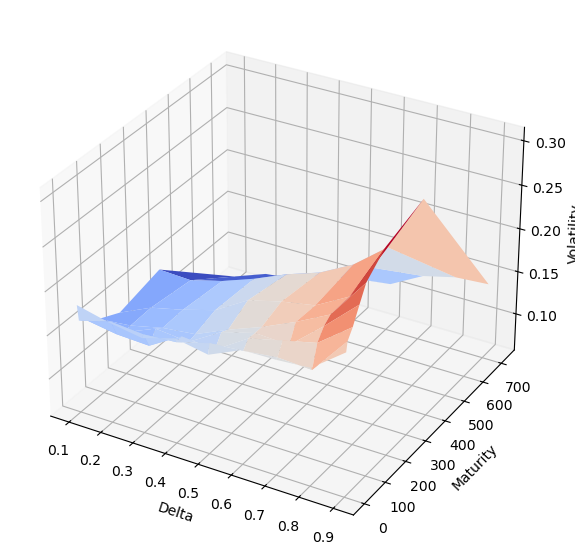

In [119]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
vae_gen.refresh()
vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
maturity, delta = np.meshgrid(maturity_grid, delta_grid)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(delta, maturity, vol_to_plot, cmap='coolwarm')  # Swap maturity and delta

# Add labels and color bar
ax.set_xlabel('Delta')  # Update label
ax.set_ylabel('Maturity')  # Update label
ax.set_zlabel('Volatility')
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

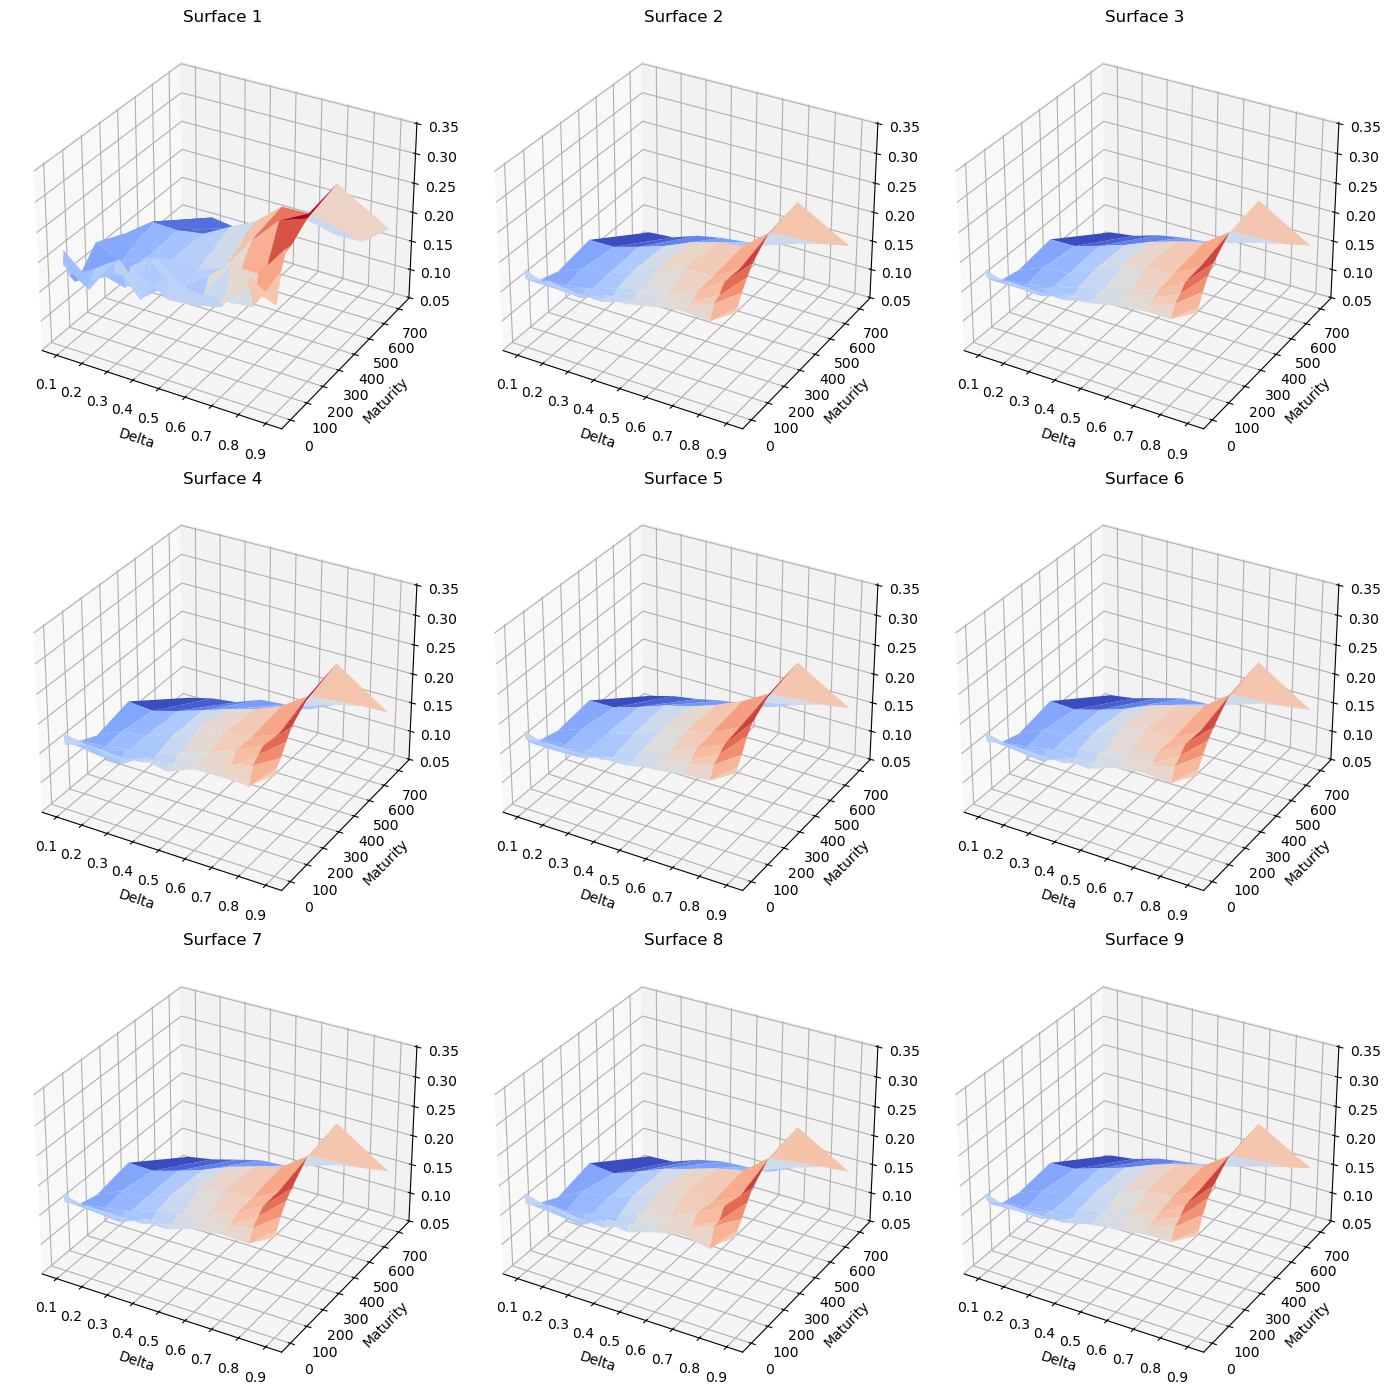

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize figure and axes grid
fig = plt.figure(figsize=(14, 14))
axes = [[fig.add_subplot(3, 3, i*3+j+1, projection='3d') for j in range(3)] for i in range(3)]

# First pass: generate all plots and collect z-limits
z_mins, z_maxs = [], []
for i in range(3):
    for j in range(3):
        # Generate new volatility surface
        vae_gen.refresh()
        vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
        d, m = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

        # Plot on pre-created axes
        ax = axes[i][j]
        surf = ax.plot_surface(d, m, vol_to_plot, cmap='coolwarm')
        
        # Configure axis labels
        ax.set_xlabel('Delta')
        ax.set_ylabel('Maturity')
        ax.set_title(f'Surface {i*3+j+1}')
        
        # Collect z-limits
        z_mins.append(vol_to_plot.min())
        z_maxs.append(vol_to_plot.max())

# Calculate global z-axis limits with padding
global_zmin = min(z_mins)
global_zmax = max(z_maxs)
padding = 0.05 * (global_zmax - global_zmin)

# Second pass: apply consistent z-axis limits
for row in axes:
    for ax in row:
        ax.set_zlim(global_zmin - padding, global_zmax + padding)

plt.tight_layout()
plt.show()

# Compare Grid and Pointwise using a short ttm

In [98]:
delta_grid = np.linspace(0.1, 0.9, 9)
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360])
data_dir = CSV_PATH + "/predicted_vol_surfaces_shortttm.json"
df_short = df[df['ttm'] <= 360]
with open(data_dir, "r") as f:
    data = json.load(f)

mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}
df_short['mapping_ids'] = df_short['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D
data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df_short[['moneyness', 'ttm']].values, dtype=torch.float32)
pw_vol_data = torch.tensor(df_short['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df_short['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_64755/1004132995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['mapping_ids'] = df_short['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)


In [108]:
model_name = "vae_0_short"
train_model = True
load_model = False
save_model = True
batch_size = 32
epochs = 50

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_short = Trainer(model_name)
trainer_short.create_model()

dataset = TensorDataset(data_tensor, dummy_labels)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_short.batch_size,
    shuffle=True
)

# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_short.train(train_loader)

if save_model:
    torch.save(
        trainer_short.model.state_dict(), f"params/{trainer_short.model_name}.pth"
    )

[2025-04-22 19:26:51] [INFO] src.train (62) : Using device: mps
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 1/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 1/50
[2025-04-22 19:26:51] [INFO] src.train (181) : Loss: 4.8859
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 2/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 2/50
[2025-04-22 19:26:51] [INFO] src.train (181) : Loss: 1.4758
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 3/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 3/50
[2025-04-22 19:26:51] [INFO] src.train (181) : Loss: 1.0695
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 4/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 4/50
[2025-04-22 19:26:51] [INFO] src.train (181) : Loss: 0.9311
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 5/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 5/50
[2025-04-22 19:26:51] [INFO] src.train (181) : Loss: 0.7648
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 6/50
[2025-04-22 19:26:51] [INFO] train (22) : Epoch 6/50


In [109]:
trainer_short.model

VAE(
  (encoder): VaeEncoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=63, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=4, bias=True)
      (activation): ReLU()
    )
  )
  (decoder): VaeDecoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=2, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=63, bias=True)
      (activation): ReLU()
    )
  )
)

In [102]:
trainer_short.load_model( f"params/{trainer_short.model_name}.pth")
vae_gen = VAEVolSurface(
    vae_model=trainer_short.model
)
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

[2025-04-22 16:01:03] [INFO] src.train (138) : Model loaded from params/vae_0_short.pth


array([[0.1768004 , 0.1622063 , 0.1854549 , 0.18742964, 0.193773  ,
        0.19231388, 0.17674543],
       [0.1736894 , 0.16329299, 0.16309223, 0.16100307, 0.14897746,
        0.16066629, 0.1512919 ],
       [0.17410159, 0.15731485, 0.15406585, 0.15006384, 0.15582147,
        0.15037705, 0.16708015],
       [0.17442507, 0.18143778, 0.17594902, 0.16502264, 0.15879543,
        0.15841444, 0.16172272],
       [0.16857174, 0.16390188, 0.17120832, 0.17880633, 0.17236361,
        0.18551669, 0.1899344 ],
       [0.19320473, 0.18550572, 0.17693509, 0.18683748, 0.19067283,
        0.19640909, 0.19598122],
       [0.18797669, 0.18974447, 0.18647811, 0.2003907 , 0.19965257,
        0.20638406, 0.21691763],
       [0.21658956, 0.19311386, 0.20555106, 0.21944375, 0.22087802,
        0.23132317, 0.2410609 ],
       [0.23822086, 0.24062203, 0.22984746, 0.24953026, 0.2514856 ,
        0.2761323 , 0.36473984]], dtype=float32)

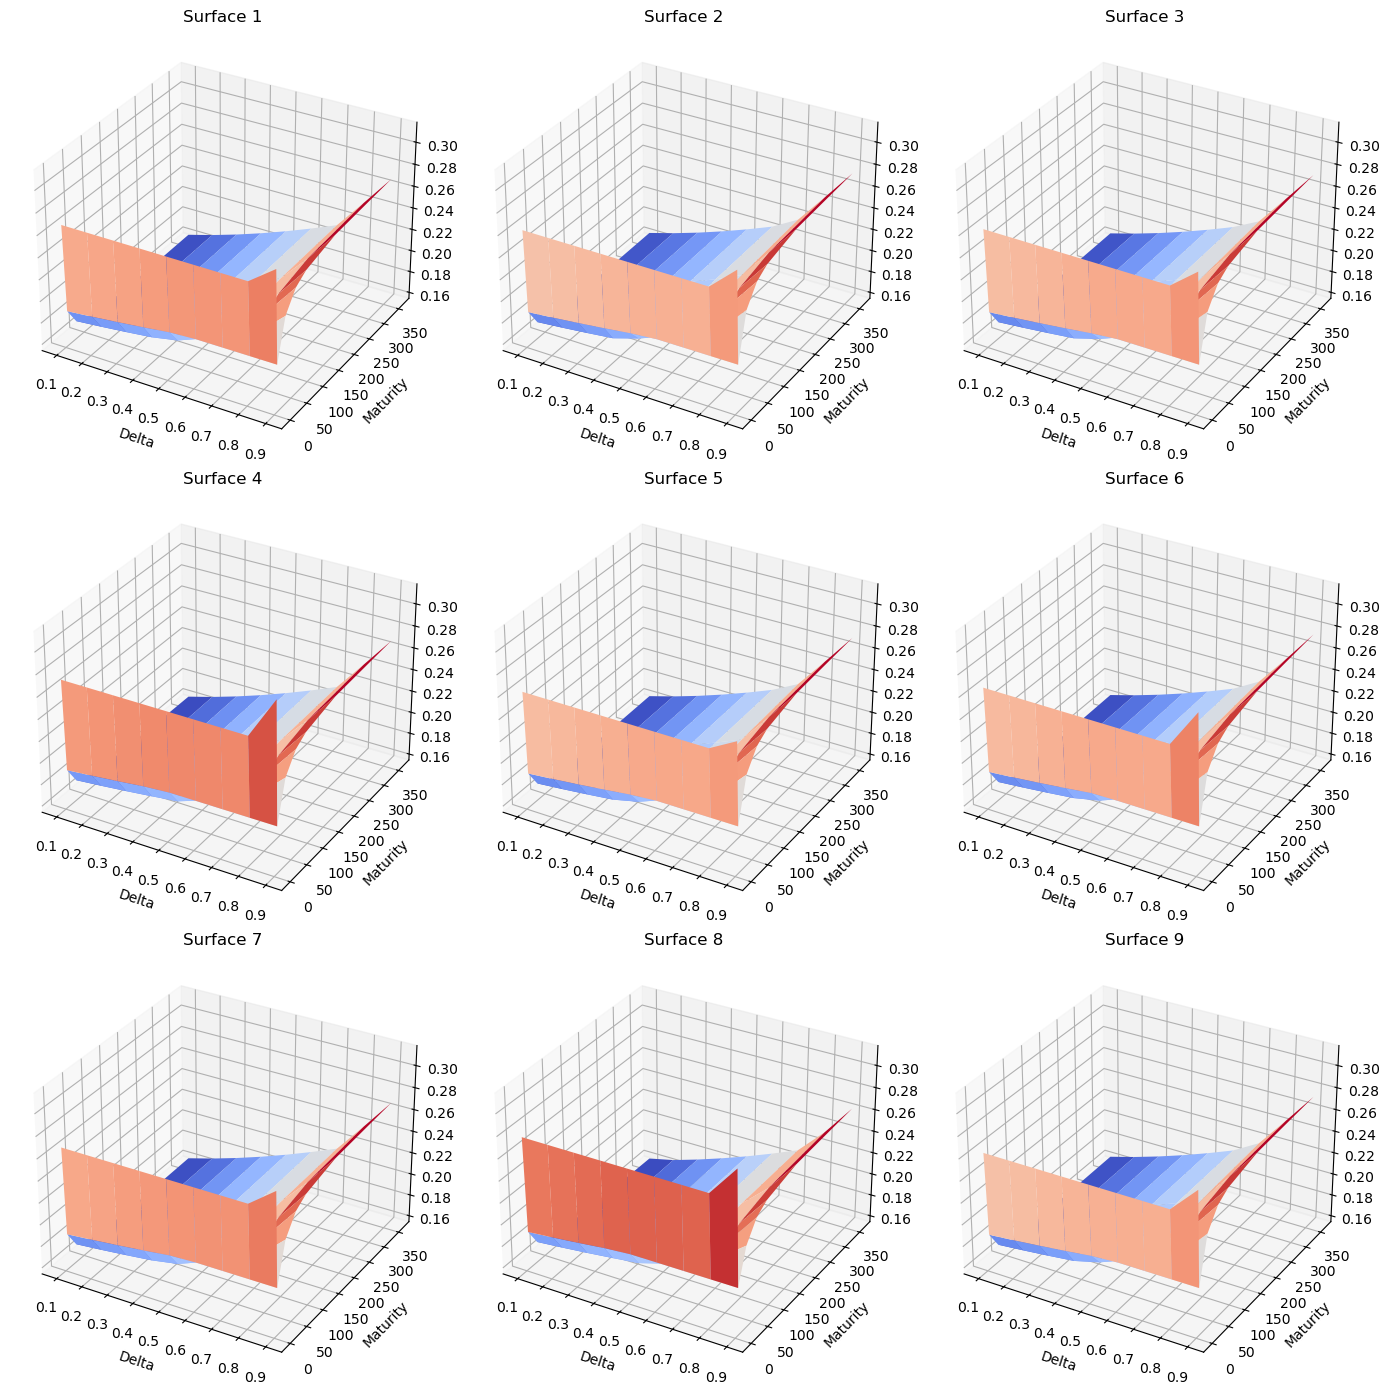

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize figure and axes grid
fig = plt.figure(figsize=(14, 14))
axes = [[fig.add_subplot(3, 3, i*3+j+1, projection='3d') for j in range(3)] for i in range(3)]

# First pass: generate all plots and collect z-limits
z_mins, z_maxs = [], []
for i in range(3):
    for j in range(3):
        # Generate new volatility surface
        vae_gen.refresh()
        vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
        d, m = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

        # Plot on pre-created axes
        ax = axes[i][j]
        surf = ax.plot_surface(d, m, vol_to_plot, cmap='coolwarm')
        
        # Configure axis labels
        ax.set_xlabel('Delta')
        ax.set_ylabel('Maturity')
        ax.set_title(f'Surface {i*3+j+1}')
        
        # Collect z-limits
        z_mins.append(vol_to_plot.min())
        z_maxs.append(vol_to_plot.max())

# Calculate global z-axis limits with padding
global_zmin = min(z_mins)
global_zmax = max(z_maxs)
padding = 0.05 * (global_zmax - global_zmin)

# Second pass: apply consistent z-axis limits
for row in axes:
    for ax in row:
        ax.set_zlim(global_zmin - padding, global_zmax + padding)

plt.tight_layout()
plt.show()

In [104]:
# pw short ttm
model_name = "vae_pw_ii_short"
train_model = True
load_model = False
save_model = True
batch_size = 32
epochs = 10

SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_short_2 = Trainer(model_name)
trainer_short_2.create_model()

dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_short_2.batch_size,
    shuffle=True
)

# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_short_2.train(train_loader)

if save_model:
    torch.save(
        trainer_short_2.model.state_dict(), f"params/{trainer_short_2.model_name}.pth"
    )

[2025-04-22 16:03:43] [INFO] src.train (62) : Using device: mps
[2025-04-22 16:03:43] [INFO] train (23) : Epoch 1/10
[2025-04-22 16:03:43] [INFO] train (23) : Epoch 1/10
[2025-04-22 16:04:55] [INFO] src.train (181) : Loss: 0.0056
[2025-04-22 16:04:55] [INFO] train (23) : Epoch 2/10
[2025-04-22 16:04:55] [INFO] train (23) : Epoch 2/10
[2025-04-22 16:06:05] [INFO] src.train (181) : Loss: 0.0041
[2025-04-22 16:06:05] [INFO] train (23) : Epoch 3/10
[2025-04-22 16:06:05] [INFO] train (23) : Epoch 3/10
[2025-04-22 16:07:19] [INFO] src.train (181) : Loss: 0.0039
[2025-04-22 16:07:19] [INFO] train (23) : Epoch 4/10
[2025-04-22 16:07:19] [INFO] train (23) : Epoch 4/10
[2025-04-22 16:08:32] [INFO] src.train (181) : Loss: 0.0038
[2025-04-22 16:08:32] [INFO] train (23) : Epoch 5/10
[2025-04-22 16:08:32] [INFO] train (23) : Epoch 5/10
[2025-04-22 16:09:47] [INFO] src.train (181) : Loss: 0.0037
[2025-04-22 16:09:47] [INFO] train (23) : Epoch 6/10
[2025-04-22 16:09:47] [INFO] train (23) : Epoch 6/10


In [105]:
trainer_short_2.load_model( f"params/{trainer_short_2.model_name}.pth")
vae_gen = VAEPWVolSurface(
    vae_model=trainer_short_2.model
)
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

[2025-04-22 16:18:42] [INFO] src.train (138) : Model loaded from params/vae_pw_ii_short.pth


array([[0.2636574 , 0.18574423, 0.16981469, 0.16456501, 0.16248398,
        0.16414441, 0.16528329],
       [0.26356766, 0.18794364, 0.1720141 , 0.16676442, 0.16827679,
        0.17074493, 0.1718838 ],
       [0.2634774 , 0.19040322, 0.17447369, 0.17337787, 0.17564015,
        0.17810829, 0.17924717],
       [0.2633862 , 0.1931101 , 0.17718056, 0.18146656, 0.18372883,
        0.18619698, 0.18733586],
       [0.26329267, 0.19605082, 0.18481266, 0.19024275, 0.19250502,
        0.19497316, 0.19611205],
       [0.26319483, 0.19800296, 0.19423524, 0.19966532, 0.2019276 ,
        0.20439574, 0.20553462],
       [0.26309028, 0.19800296, 0.20424818, 0.20967826, 0.21194054,
        0.21516776, 0.21854705],
       [0.26297736, 0.19800296, 0.21474981, 0.2284687 , 0.23536967,
        0.24282381, 0.24620311],
       [0.29066613, 0.19800296, 0.24017948, 0.25685754, 0.2637585 ,
        0.27121264, 0.27468213]], dtype=float32)

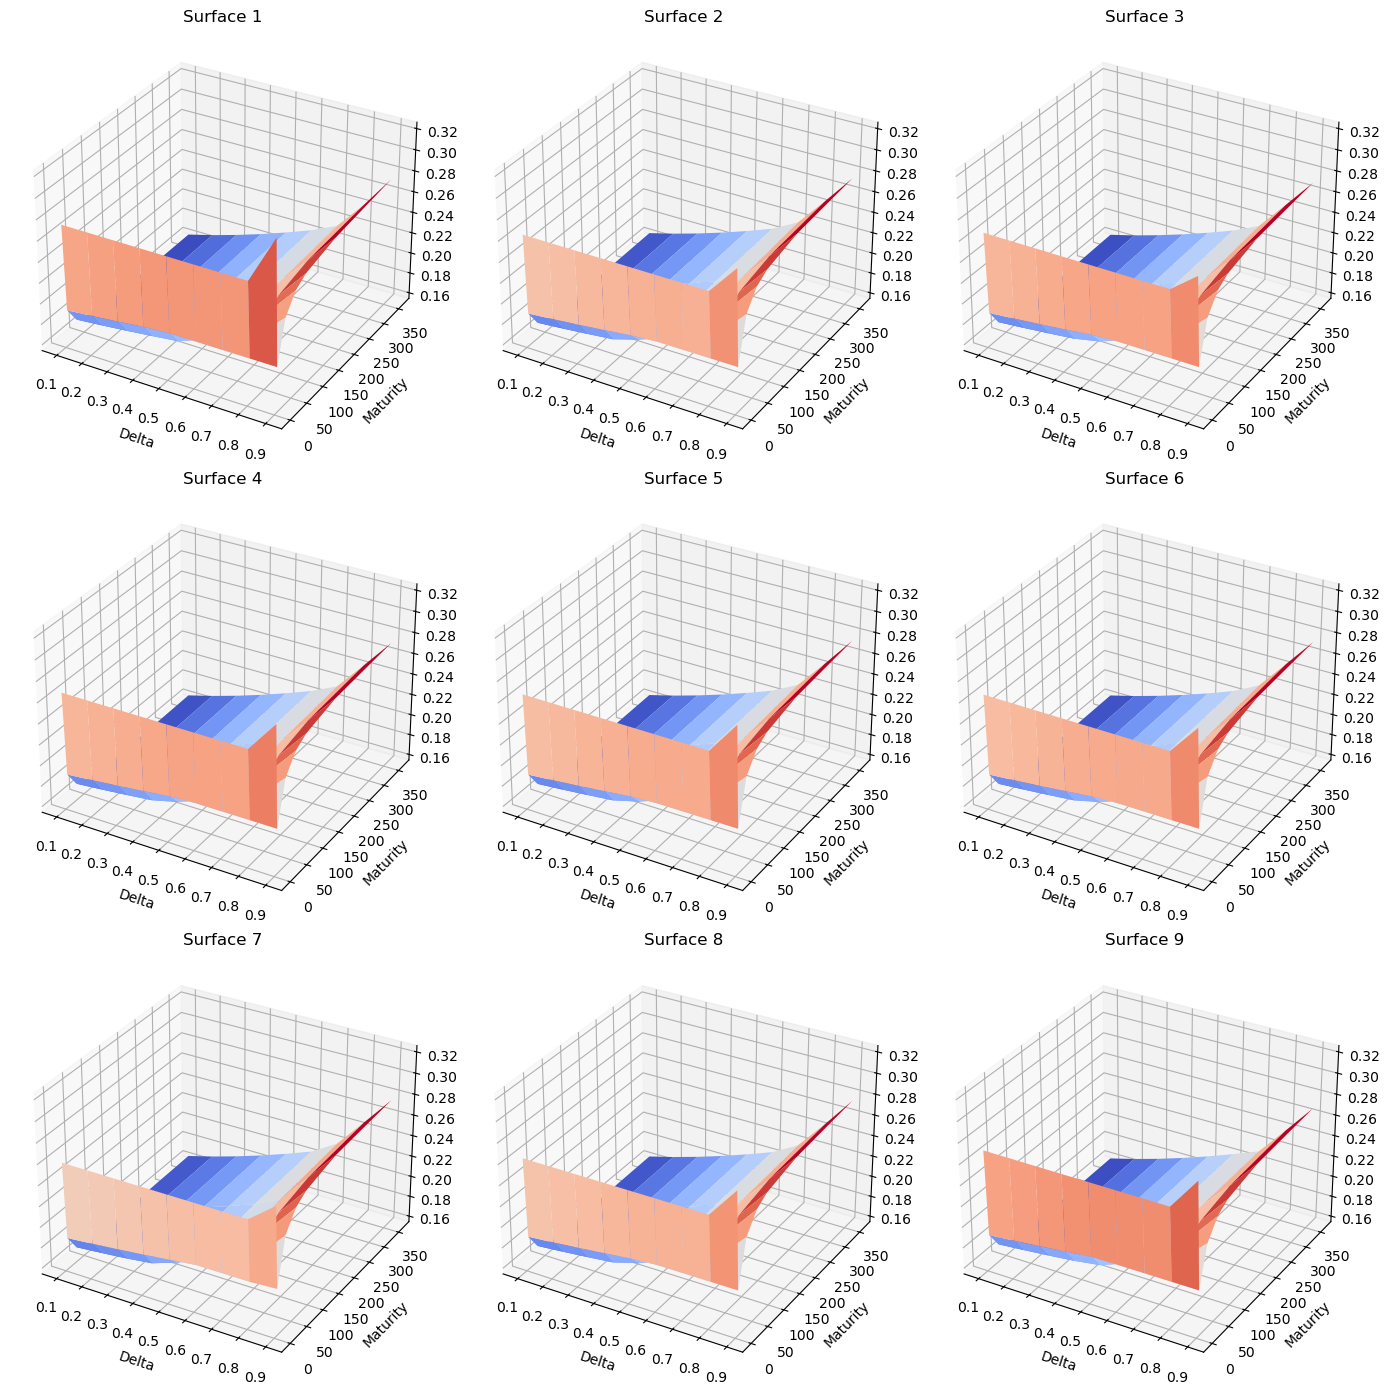

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize figure and axes grid
fig = plt.figure(figsize=(14, 14))
axes = [[fig.add_subplot(3, 3, i*3+j+1, projection='3d') for j in range(3)] for i in range(3)]

# First pass: generate all plots and collect z-limits
z_mins, z_maxs = [], []
for i in range(3):
    for j in range(3):
        # Generate new volatility surface
        vae_gen.refresh()
        vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
        d, m = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

        # Plot on pre-created axes
        ax = axes[i][j]
        surf = ax.plot_surface(d, m, vol_to_plot, cmap='coolwarm')
        
        # Configure axis labels
        ax.set_xlabel('Delta')
        ax.set_ylabel('Maturity')
        ax.set_title(f'Surface {i*3+j+1}')
        
        # Collect z-limits
        z_mins.append(vol_to_plot.min())
        z_maxs.append(vol_to_plot.max())

# Calculate global z-axis limits with padding
global_zmin = min(z_mins)
global_zmax = max(z_maxs)
padding = 0.05 * (global_zmax - global_zmin)

# Second pass: apply consistent z-axis limits
for row in axes:
    for ax in row:
        ax.set_zlim(global_zmin - padding, global_zmax + padding)

plt.tight_layout()
plt.show()

# filter out extremely large volatilities (outliers) in pw_vol and the corresponding pw_grid

In [33]:
df_clipped = df[df['impl_volatility'] < 0.5]
print(f"retained percentage: {len(df_clipped) / len(df) * 100:.2f}%")

retained percentage: 99.07%


In [34]:
model_name = "vae_pw_improve_1"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [35]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [36]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_1 = Trainer(model_name)
trainer_1.create_model()

[2025-04-20 16:04:39] [INFO] src.train (61) : Using device: mps


In [37]:
pw_grid_data = torch.tensor(df_clipped[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df_clipped['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df_clipped['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [38]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_1.batch_size,
    shuffle=True
)

In [40]:
trainer_1.hypertune(train_loader)


2025-04-20 16:07:16,547	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Hypertune!! {'learning_rate': <ray.tune.search.sample.Categorical object at 0x3b5ba9b70>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x3b5ba9960>, 'latent_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9cf0>, 'hidden_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9c90>, 'input_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9c00>}


E0000 00:00:1745179636.666257 2848300 tcp_posix.cc:596] recvmsg encountered uncommon error: Message too long


== Status ==
Current time: 2025-04-20 16:07:17 (running for 00:00:00.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 PENDING)


== Status ==
Current time: 2025-04-20 16:07:22 (running for 00:00:05.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 RUNNING)


== Status ==
Current time: 2025-04-20 16:07:27 (running for 00:00:10.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: No

2025-04-20 16:33:05,018	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/zlx/ray_results/lambda_2025-04-20_16-07-16' in 0.0029s.
2025-04-20 16:33:05,021	INFO tune.py:1041 -- Total run time: 1548.47 seconds (1548.36 seconds for the tuning loop).


== Status ==
Current time: 2025-04-20 16:33:05 (running for 00:25:48.37)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5751.433558963705 | Iter 1.000: -5731.989296980668
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 TERMINATED)


Best config: {'learning_rate': 0.0001, 'batch_size': 64, 'latent_dim': 4, 'hidden_dim': [32, 32], 'input_dim': 72}


In [41]:
# Train the model after tune
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_1.train(train_loader)

[2025-04-20 16:41:02] [INFO] train (3) : Epoch 1/10
[2025-04-20 16:43:08] [INFO] src.train (180) : Loss: 0.0047
[2025-04-20 16:43:08] [INFO] train (3) : Epoch 2/10
[2025-04-20 16:45:16] [INFO] src.train (180) : Loss: 0.0034
[2025-04-20 16:45:16] [INFO] train (3) : Epoch 3/10
[2025-04-20 16:47:27] [INFO] src.train (180) : Loss: 0.0033
[2025-04-20 16:47:27] [INFO] train (3) : Epoch 4/10
[2025-04-20 16:49:37] [INFO] src.train (180) : Loss: 0.0032
[2025-04-20 16:49:37] [INFO] train (3) : Epoch 5/10
[2025-04-20 16:51:52] [INFO] src.train (180) : Loss: 0.0031
[2025-04-20 16:51:52] [INFO] train (3) : Epoch 6/10
[2025-04-20 16:54:08] [INFO] src.train (180) : Loss: 0.0031
[2025-04-20 16:54:08] [INFO] train (3) : Epoch 7/10
[2025-04-20 16:56:20] [INFO] src.train (180) : Loss: 0.0030
[2025-04-20 16:56:20] [INFO] train (3) : Epoch 8/10
[2025-04-20 16:58:34] [INFO] src.train (180) : Loss: 0.0030
[2025-04-20 16:58:34] [INFO] train (3) : Epoch 9/10
[2025-04-20 17:00:50] [INFO] src.train (180) : Loss:

In [42]:
torch.save(trainer_1.model.state_dict(), f"params/{trainer_1.model_name}.pth")

In [43]:
trainer_1.load_model( f"params/{trainer_1.model_name}.pth")

[2025-04-20 17:07:41] [INFO] src.train (137) : Model loaded from params/vae_pw_improve_1.pth


In [46]:
trainer_1.model

VAE_PW_II(
  (encoder): VaeEncoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=72, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=8, bias=True)
      (activation): ReLU()
    )
  )
  (decoder): VaeDecoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=4, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=1, bias=True)
      (activation): ReLU()
    )
  )
  (dltemb_net): EmbeddingMLP(
    (embed_net): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=10, out_features=4, bias=True)
      )
      (output_layer): Linear(in_features=4, out_features=4, bias=True)
      (activation): SiLU()
    )
  )
  (ttmemb_net): EmbeddingMLP(
    (embed_net): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=10, out_features=4, bias=True)
      )
      (output_layer): Linear(in_features=4, out_feat

In [44]:
vae_gen_1 = VAEPWVolSurface(
    vae_model=trainer_1.model
)
vae_gen_1.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.3190164 , 1.5820023 , 2.2652268 , 2.3652933 , 2.3688467 ,
        2.279745  , 2.0626657 , 1.7391351 ],
       [0.3507371 , 1.5786883 , 2.2619128 , 2.374338  , 2.3758647 ,
        2.2764308 , 2.0593512 , 1.7358207 ],
       [0.36839586, 1.5624157 , 2.24564   , 2.358066  , 2.3595927 ,
        2.2601583 , 2.043079  , 1.7195479 ],
       [0.3786183 , 1.5504856 , 2.2337096 , 2.3461356 , 2.3476617 ,
        2.2482283 , 2.0311494 , 1.7076181 ],
       [0.38127813, 1.5401942 , 2.2234185 , 2.3358448 , 2.33737   ,
        2.2379367 , 2.0208573 , 1.6973268 ],
       [0.38039458, 1.53062   , 2.2138445 , 2.3262699 , 2.327797  ,
        2.228363  , 2.0112834 , 1.6877533 ],
       [0.3792013 , 1.5218078 , 2.205032  , 2.3174577 , 2.318984  ,
        2.2195494 , 2.0024712 , 1.6789397 ],
       [0.37886417, 1.5138584 , 2.197083  , 2.3095086 , 2.311035  ,
        2.2116008 , 1.994522  , 1.6709915 ],
       [0.37948278, 1.5068232 , 2.190047  , 2.3024735 , 2.3039997 ,
        2.2045653 , 1.987485

<Axes3D: title={'center': 'Vol Surface'}, xlabel='Delta', ylabel='Maturity (Days)', zlabel='Implied Volatility'>

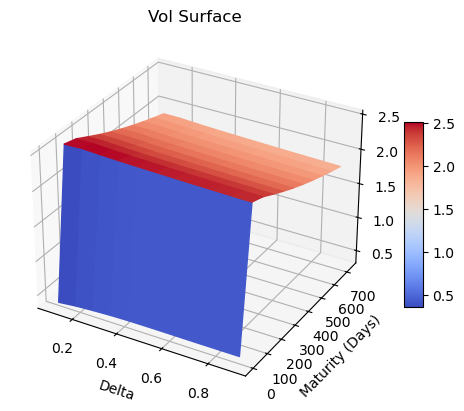

In [45]:
vae_gen_1.refresh()
vae_gen_1.plot(delta_range = (0.1, 0.9), maturity_range = (1, 720))